In [1]:
import DataProcess as DP
import glob
import time
import pandas as pd

In [2]:
#labels of columns in preprocessed data. 33 columns in total
IMUsublabels=[x+y for x in ['acc16g_','gyro_','mag_'] for y in ['x','y','z']]
col_sublabels=['timestamp','activityID','heart_rate']+[x+y for x in ['hand_','chest_','ankle_'] for y in ['temp']+IMUsublabels]

In [3]:
datafile = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject101.dat'

In [4]:
dp = DP.dataprocess(datafile)

In [5]:
test_chunk_1 = dp.chunks[3]
test_chunk_2 = dp.chunks[5]

In [6]:
test_df_1 = pd.DataFrame(test_chunk_1,columns=col_sublabels)
test_df_2 = pd.DataFrame(test_chunk_2,columns=col_sublabels)

In [7]:
test_df_2.head()

,timestamp,activityID,heart_rate,hand_temp,hand_acc16g_x,hand_acc16g_y,hand_acc16g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,...,ankle_temp,ankle_acc16g_x,ankle_acc16g_y,ankle_acc16g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z
0,1561.19,12.0,113.389831,33.8125,-6.75678,2.11249,-0.260681,-0.811168,-0.006574,3.14465,...,34.875,10.08830,-0.615307,-2.30146,-0.370361,0.116348,0.699269,-33.5973,-42.9789,22.6628
1,1561.20,12.0,113.389831,33.8125,-6.90045,2.22915,-0.070790,-0.793251,0.072475,2.84913,...,34.875,9.94784,-2.013330,-3.02742,-0.388133,0.077496,0.586212,-34.5914,-43.9384,22.7845
2,1561.21,12.0,113.389831,33.8125,-6.86427,2.56930,-0.186858,-0.771483,0.062868,2.55079,...,34.875,10.70900,-1.489400,-2.67556,-0.357442,0.119261,0.426773,-34.0560,-42.5151,22.1764
3,1561.22,12.0,113.389831,33.8125,-7.04466,2.64865,0.041097,-0.723934,0.099691,2.22170,...,34.875,11.27820,-0.430482,-2.59912,-0.313059,0.138359,0.246677,-34.2798,-42.4001,22.4270
4,1561.23,12.0,113.389831,33.8125,-7.00340,2.95221,0.079178,-0.642982,0.039600,1.87488,...,34.875,11.23720,-1.113680,-2.59530,-0.255645,0.215079,0.101028,-34.1655,-42.8389,21.9263


### Investigating some features

In [8]:
from scipy import signal, fft, integrate
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def vectorsum(X,Y,Z):
    
    return np.sqrt(np.square(X)+np.square(Y)+np.square(Z))


### Peak of Welch Peridogram

#### Spectral features of the vector sum - may save time

In [10]:
X = test_df_1['hand_acc16g_x'][:512]
Y = test_df_1['hand_acc16g_y'][:512]
Z = test_df_1['hand_acc16g_z'][:512]
hand_acc_vsum = vectorsum(X,Y,Z)

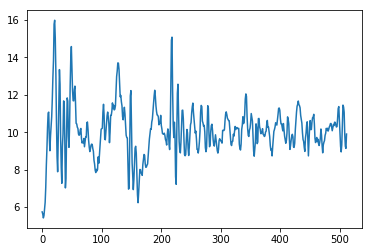

In [11]:
plt.plot(hand_acc_vsum)

In [12]:
#Determine Welch peridogram
freqs, pspec = signal.welch(hand_acc_vsum,nperseg=256,fs=100,scaling='spectrum')

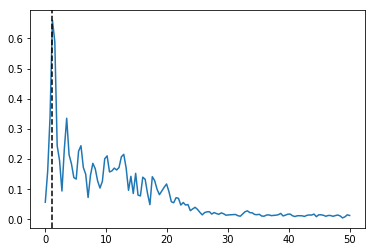

In [13]:
plt.plot(freqs, np.sqrt(pspec))
plt.axvline(x=freqs[np.argmax(pspec)],color='k',linestyle='--')

#### Is this significantly different from the peak frequency of each of the individual components?

In [14]:
freqsX, pspecX = signal.welch(X,nperseg=256,fs=100,scaling='spectrum')
freqsY, pspecY = signal.welch(Y,nperseg=256,fs=100,scaling='spectrum')
freqsZ, pspecZ = signal.welch(Z,nperseg=256,fs=100,scaling='spectrum')

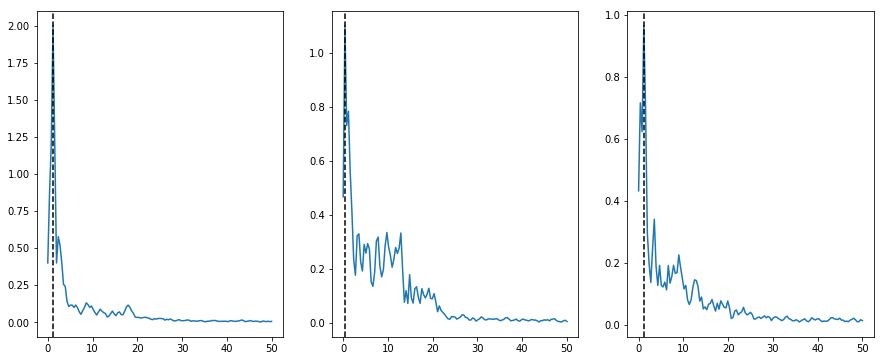

In [15]:
fig = plt.figure(figsize=(15,6))
fig.add_subplot(131)
plt.plot(freqsX, np.sqrt(pspecX))
plt.axvline(x=freqsX[np.argmax(pspecX)],color='k',linestyle='--')
fig.add_subplot(132)
plt.plot(freqsY, np.sqrt(pspecY))
plt.axvline(x=freqsY[np.argmax(pspecY)],color='k',linestyle='--')
fig.add_subplot(133)
plt.plot(freqsZ, np.sqrt(pspecZ))
plt.axvline(x=freqsX[np.argmax(pspecZ)],color='k',linestyle='--')

### Energy in the spectrum 

In [16]:
fft_X = fft(X)
fft_Y = fft(Y)
fft_Z = fft(Z)
N = int(len(X))

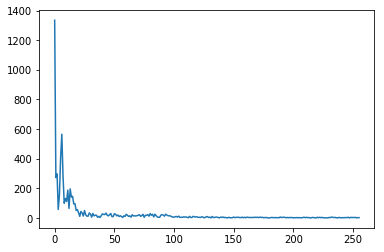

In [17]:
#Note similar shape to the peridogram: The power spectrum is just this value squared
plt.plot(np.abs(fft_X)[:int(N/2)])

In [18]:
energy_x = np.sum(np.abs(fft_X[1:int(N/2)]))/(N/2)
energy_y = np.sum(np.abs(fft_Y[1:int(N/2)]))/(N/2)
energy_z = np.sum(np.abs(fft_Z[1:int(N/2)]))/(N/2)

In [19]:
energy_x,energy_y,energy_z

(20.783972031870782, 24.078055633220554, 18.133486024313925)

### Spectral entropy

In [20]:
def spectral_entropy(X):
    
    '''
    Calculates the spectral entropy of a signal between fmin and fmax
    Details from https://www.mathworks.com/help/signal/ref/pentropy.html
    '''
    
    freqs, pspec = signal.welch(X,nperseg=256,fs=100,scaling='spectrum')
    print(freqs)
    prob = pspec/np.sum(pspec)
    return -1*np.sum(np.multiply(prob,np.log(prob)), axis=0)

In [21]:
spectral_entropy(Y)

[ 0.        0.390625  0.78125   1.171875  1.5625    1.953125  2.34375
  2.734375  3.125     3.515625  3.90625   4.296875  4.6875    5.078125
  5.46875   5.859375  6.25      6.640625  7.03125   7.421875  7.8125
  8.203125  8.59375   8.984375  9.375     9.765625 10.15625  10.546875
 10.9375   11.328125 11.71875  12.109375 12.5      12.890625 13.28125
 13.671875 14.0625   14.453125 14.84375  15.234375 15.625    16.015625
 16.40625  16.796875 17.1875   17.578125 17.96875  18.359375 18.75
 19.140625 19.53125  19.921875 20.3125   20.703125 21.09375  21.484375
 21.875    22.265625 22.65625  23.046875 23.4375   23.828125 24.21875
 24.609375 25.       25.390625 25.78125  26.171875 26.5625   26.953125
 27.34375  27.734375 28.125    28.515625 28.90625  29.296875 29.6875
 30.078125 30.46875  30.859375 31.25     31.640625 32.03125  32.421875
 32.8125   33.203125 33.59375  33.984375 34.375    34.765625 35.15625
 35.546875 35.9375   36.328125 36.71875  37.109375 37.5      37.890625
 38.28125  38.6718

3.0940096599303692

In [22]:
def power_ratio(pspec,freqs,band1,band2):
    
    '''
    Calcualates the power ratio between bands 1 and 2 by integrating the spectrogram
    '''
    
    i1 = np.argmin(abs(freqs - band1[0]))
    i2 = np.argmin(abs(freqs - band1[1]))
    
    i3 = np.argmin(abs(freqs - band2[0]))
    i4 = np.argmin(abs(freqs - band2[1]))
    
    pv1 = integrate.simps(pspec[i1:i2],freqs[i1:i2])
    pv2 = integrate.simps(pspec[i3:i4],freqs[i3:i4])
    
    return (pv1/pv2)

### Autocorrelation

In [102]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf

In [103]:
X = test_df_1['hand_acc16g_x'][:512]
Y = test_df_1['hand_acc16g_y'][:512]
Z = test_df_1['hand_acc16g_z'][:512]
hand_acc_vsum = vectorsum(X,Y,Z)

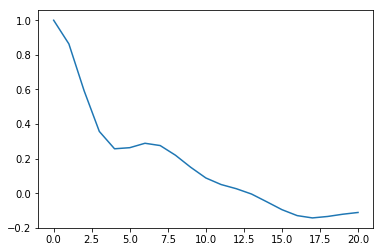

In [104]:
autocorrelation = acf(hand_acc_vsum,nlags=20,unbiased=True)
plt.plot(autocorrelation)

In [108]:
gradient = (autocorrelation[4]-autocorrelation[0])/5
gradient

-0.1486569759095292

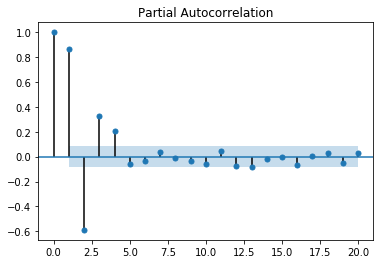

In [105]:
p = plot_pacf(hand_acc_vsum,lags=20)

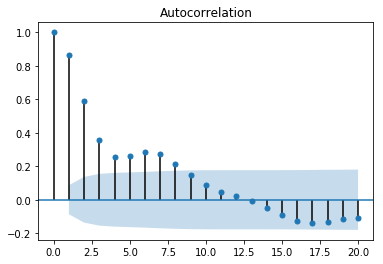

In [106]:
a = plot_acf(hand_acc_vsum,lags=20)

In [70]:
X = test_df_2['hand_acc16g_x'][:512]
Y = test_df_2['hand_acc16g_y'][:512]
Z = test_df_2['hand_acc16g_z'][:512]

In [71]:
hand_acc_vsum = pd.Series(vectorsum(X,Y,Z))

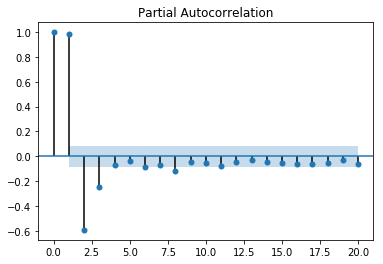

In [72]:
p = plot_pacf(hand_acc_vsum,lags=20)

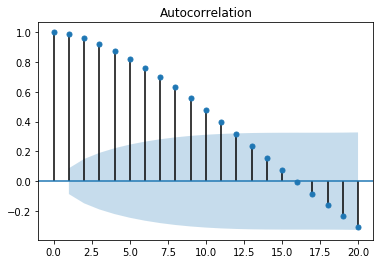

In [73]:
a = plot_acf(hand_acc_vsum,lags=20)

In [47]:
heart_rate = test_df_2['heart_rate'][:512]

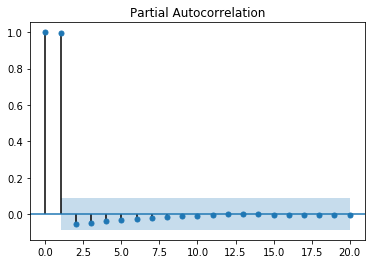

In [57]:
p = plot_pacf(heart_rate,lags=20)

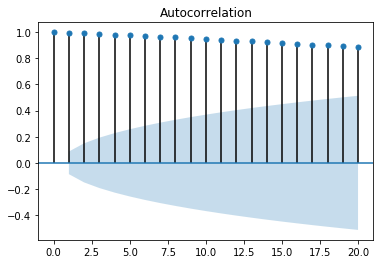

In [56]:
a = plot_acf(heart_rate,lags=20)